In [1]:
import random
from IPython.display import clear_output
from collections import deque

import gym
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


This is a very simple <b>Deep Q learning</b> model with <b>experience replay</b> for solving the Cartpole problem. <br>
The Cartpole problem was to find an agent that can help the pole to balance for a long period. Since the observation space is continous (i.e. infinitely many states), it is natural to use approximation methods instead of traditional tabular Q learning methods.

In [17]:
class DQN:
    def __init__(self, sizes, gamma=1, epsilon=1, batch_size=128):
        self.env = gym.make('CartPole-v0')
        self.nS = self.env.observation_space.shape[0]
        self.nA = self.env.action_space.n
        self.gamma = gamma
        self.epsilon = epsilon
        self.batch_size = batch_size
        self.experience = deque(maxlen=100000)
        
        self.model = tf.keras.Sequential()
        self.model.add(tf.keras.layers.Input(shape = (self.nS,)))
        for size in sizes:
            self.model.add(tf.keras.layers.Dense(size, activation='relu'))
        self.model.add(tf.keras.layers.Dense(self.nA, activation='linear'))

        self.callbacks = [
#         tf.keras.callbacks.TensorBoard(log_dir=f'/DQN_logs/run_{run}'), 
#              tf.keras.callbacks.ModelCheckpoint(filepath='DQN_check_point/model.{epoch:02d}.h5'),
             tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=1e-5, patience=3)]
        self.model.compile(loss=tf.keras.losses.mean_squared_error, optimizer='Adam')
    
    
    def choose_action(self, Q_value):
        # epsilon greedy method
        if np.random.uniform() < self.epsilon:
            return self.env.action_space.sample()
        else:
            return np.argmax(Q_value)
    
    def evaluate(self):
        end = False
        state = self.env.reset()
        total_reward = 0
        while not end:
            Q_values = self.model.predict(state.reshape(1, self.nS))[0]
            action = np.argmax(Q_values)
            state, reward, end, _ = self.env.step(action)
            total_reward += reward
        return total_reward
    
    def simulation(self):
        state = self.env.reset()
        end = False
        
        while not end:
            Q_values = self.model.predict(state.reshape(1, self.nS))[0]
            action = self.choose_action(Q_values)
            next_state, reward, end, _ = self.env.step(action)
            self.experience.append((state, action, reward, next_state, end))
            state = next_state
            
        
    def train(self, max_epoch=1000):
        scores = []
        
        for epoch in range(max_epoch):
            self.simulation()

            # train by using experience replay
            X = []
            y_true = []
            records = random.sample(self.experience, min(self.batch_size, len(self.experience)))
            for state, action, reward, next_state, end in records:
                Q_values = self.model.predict(state.reshape(1, self.nS))[0]
                next_Q_values = self.model.predict(next_state.reshape(1, self.nS))[0]
                Q_values[action] = reward + (1 - end) * self.gamma * next_Q_values.max()
                X.append(state)
                y_true.append(Q_values)
            self.model.fit(np.vstack(X), np.vstack(y_true), callbacks = self.callbacks, epochs=10, verbose=0)
            
            score = self.evaluate()
            scores.append(score)
            clear_output(True)
            plt.plot(scores)
            plt.show()
            
            print(f'epoch {epoch} with score {score}')
            latest = np.mean([scores[-10:]])
            if latest > 150:
                print(f'epoch {epoch} solved the problem with average score {latest}')
                break
            
        self.epsilon = min(self.epsilon * 0.95, 0.01)

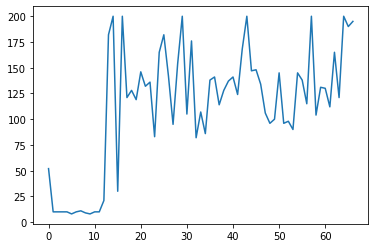

epoch 66 with score 195.0
epoch 66 solved the problem with average score 154.8


In [19]:
model = DQN([24, 16, 8])
model.train()